In [1]:
import os
import time
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# function for loading the dataset
def load_images(data_dir, class_names):
    images = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # load as grayscale
            images.append(image)
            labels.append(class_idx)
    return images, labels

### FEATURE EXTRACTION

In [ ]:
def visualize_keypoints(images, keypoints, num_of_images=3):
    output_images = []
    for x in range(num_of_images):
        output_image = cv2.drawKeypoints(images[x], keypoints[x], 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        output_images.append(output_image)
    fig, axs = plt.subplots(1, num_of_images, figsize=(5*num_of_images, 5))
    for i in range(num_of_images):
        axs[i].imshow(output_images[i], cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# feature extraction function
def function_extraction(images, method="SIFT", visualize=False):
    all_descriptions = []
    all_keypoints = []
    for img in images:
        if method == "SIFT":
            descriptor = cv2.SIFT_create()
        elif method == "SIFT_LOWE":
            descriptor = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09)
        elif method == "ORB":
            descriptor = cv2.ORB_create(nfeatures=250,scaleFactor=2)
        else:
            return None
        keypoints, descriptors = descriptor.detectAndCompute(img, None) # detect keypoints and descriptors
        if descriptors is None:
            if method == "ORB":
                descriptors = np.zeros((1,32), dtype=np.uint8)
            else:
                descriptors = np.zeros((1, 128), dtype=np.float32)
        all_descriptions.append(descriptors)
        all_keypoints.append(keypoints)
    if visualize:
        visualize_keypoints(images, all_keypoints)
    return all_descriptions

In [ ]:
def prep_descriptions(all_descriptions):
    all_descriptions_stacked = []
    for descs in all_descriptions:
        for desc in descs:
            all_descriptions_stacked.append(desc)
    all_descriptions_stacked = np.stack(all_descriptions_stacked)
    return all_descriptions_stacked

### VECTOR QUANTIZATION WITH K-MEANS AND FORMING THE BOVW

In [ ]:
def run_kmeans(data, num_clusters, max_iter=300):
    kmeans = KMeans(n_clusters = num_clusters)
    kmeans.fit(data)
    return kmeans

In [ ]:
def quantize_images(kmeans, all_descriptions):
    quantized_images = []
    for descriptions in all_descriptions:
        quantized_values = []
        for desc in descriptions:
            desc = desc.reshape(1, -1) # for calculation purposes
            cluster_center = kmeans.predict(desc)
            quantized_values.append(cluster_center[0]) # indexing is again for calculation purposes
        quantized_images.append(quantized_values)
    return quantized_images

### CREATING HISTOGRAMS

In [ ]:
def create_frequency_vectors(quantized_images,num_clusters):
    frequency_vectors = []
    for quantized_img in quantized_images:
        # create a frequency vector for each image
        img_frequency_vector = np.zeros(num_clusters)
        for visual_word in quantized_img:
            img_frequency_vector[visual_word] += 1
        frequency_vectors.append(img_frequency_vector)
    # stack together in numpy array
    frequency_vectors = np.stack(frequency_vectors)
    return frequency_vectors

In [ ]:
def visualize_hists(frequency_vectors):
    num_plots = len(frequency_vectors)
    fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))
    for i, freq_vector in enumerate(frequency_vectors):
        axs[i].bar(list(range(len(freq_vector))), freq_vector)
        axs[i].set_title(f'Histogram {i+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
def transform_to_hist(desc_stacked, sift_descriptions, num_of_clusters):
    kmeans = run_kmeans(desc_stacked, num_of_clusters)
    vq = quantize_images(kmeans, sift_descriptions)
    hist_img_data = create_frequency_vectors(vq, num_of_clusters)
    return hist_img_data

### CLASSIFYING THE IMAGES AND VISUALIZATIONS

In [ ]:
def classify_images(train_hists, train_labels, test_hists, k=5, distance="euclidean"):
    knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
    knn.fit(train_hists, train_labels)
    predictions = knn.predict(test_hists)
    return predictions

In [ ]:
def visualize_performance(accuracy, cm, time):
    print("Classification accuracy:", accuracy)
    print("Runtime:", time)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def visualize_predictions(predictions, test_labels):
    num_samples = 5
    sample_indices = np.random.choice(len(test_images), num_samples)
    sample_images = [test_images[i] for i in sample_indices]
    sample_predictions = [predictions[i] for i in sample_indices]
    sample_real_labels = [test_labels[i] for i in sample_indices]

    # display the images with their predicted and real labels
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (image, prediction, real_label) in enumerate(zip(sample_images, sample_predictions, sample_real_labels)):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted: {prediction}\nActual: {real_label}")
        axes[i].axis("off")

    plt.show()

### CODE RUN

In [ ]:
TRAIN_DIR = "imagenette2/train"
class_names_train = sorted(os.listdir(TRAIN_DIR))
TEST_DIR = "imagenette2/val"
class_names_test = sorted(os.listdir(TEST_DIR))

In [ ]:
# load train images and test images
train_images, train_labels = load_images(TRAIN_DIR, class_names_train)
test_images, test_labels = load_images(TEST_DIR, class_names_test)

### EXPERIMENT WITH SIFT

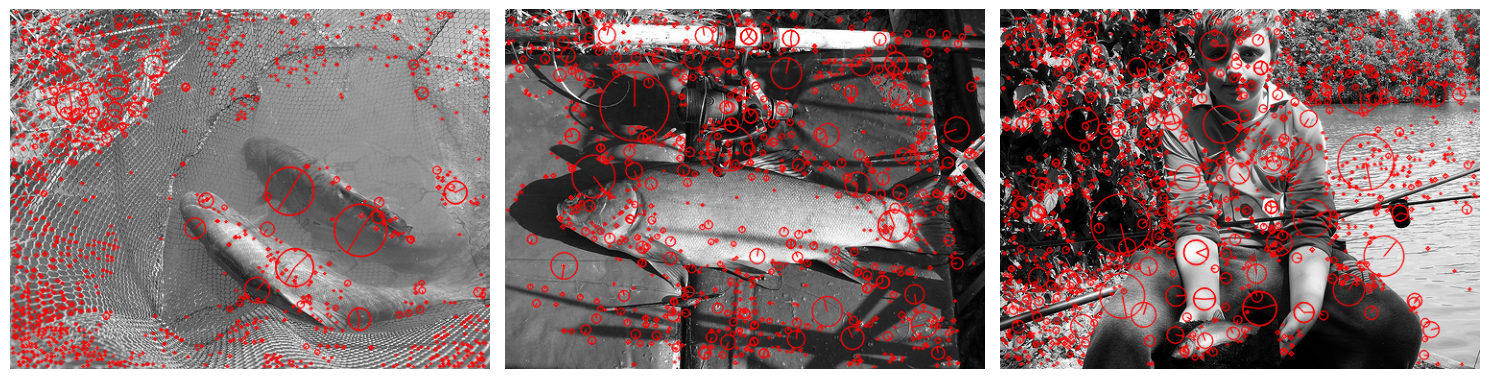

In [ ]:
# train data transformation
sift_descriptions_train = function_extraction(train_images, method="SIFT",visualize=True)
sift_desc_stacked_train = prep_descriptions(sift_descriptions_train)

In [ ]:
# test data transformation
sift_descriptions_test = function_extraction(test_images, method="SIFT")
sift_desc_stacked_test = prep_descriptions(sift_descriptions_test)

In [ ]:
# experiment with 70 cluster and SIFT and k = 5
hist_img_data_train_70 = transform_to_hist(sift_desc_stacked_train,sift_descriptions_train, 70)
hist_img_data_test_70 = transform_to_hist(sift_desc_stacked_test, sift_descriptions_test, 70)

Classification accuracy: 0.15388535031847134
Runtime: 0.2252495288848877


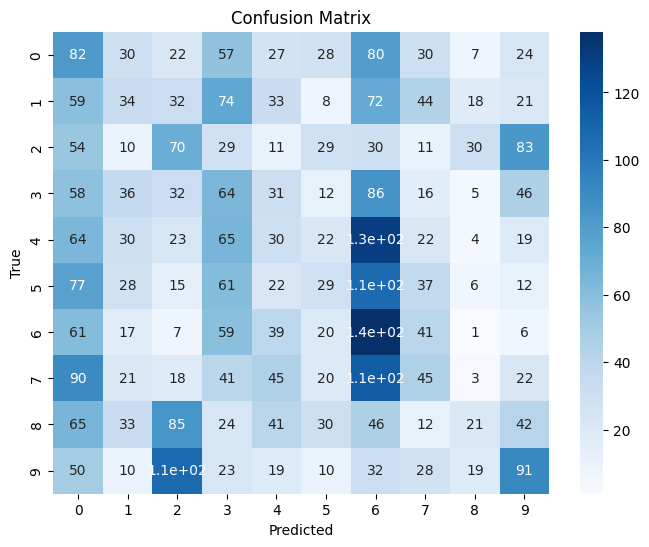

In [ ]:
# knn with euclidean
start_time = time.time()
predictions_70_euc = classify_images(hist_img_data_train_70, train_labels, hist_img_data_test_70)
end_time = time.time()
time_70_euc = end_time - start_time
accuracy_70_euc = accuracy_score(test_labels, predictions_70_euc)
cm_70_euc = confusion_matrix(test_labels, predictions_70_euc)
visualize_performance(accuracy_70_euc, cm_70_euc, time_70_euc)

### EXPERIMENT WITH SIFT WITH PARAMETERS

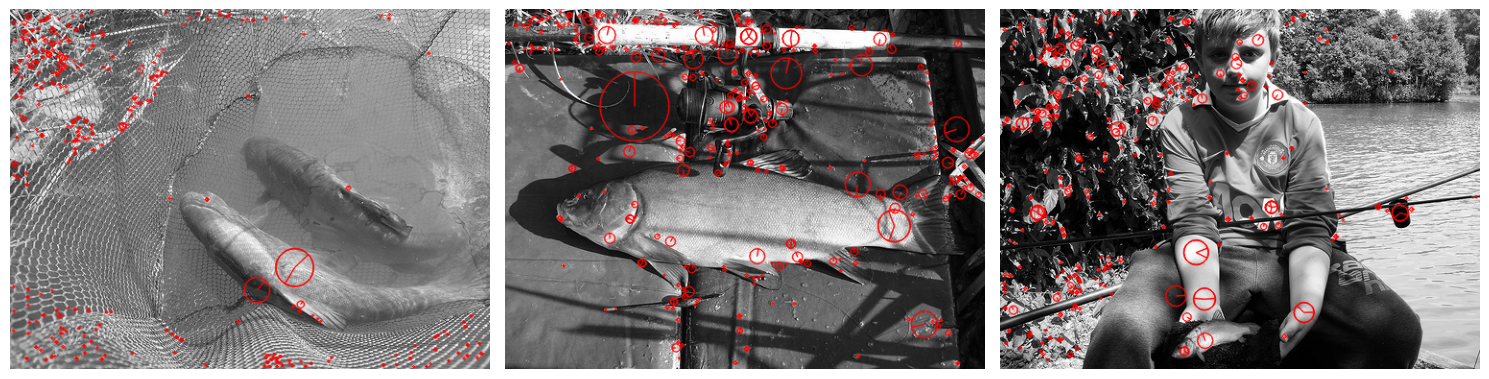

In [ ]:
# train data transformation
sift_descriptions_train = function_extraction(train_images, method="SIFT_LOWE",visualize=True)
sift_desc_stacked_train = prep_descriptions(sift_descriptions_train)

In [ ]:
# test data transformation
sift_descriptions_test = function_extraction(test_images, method="SIFT_LOWE")
sift_desc_stacked_test = prep_descriptions(sift_descriptions_test)

In [ ]:
# experiment with 30 cluster and SIFT_PARAMETER
hist_img_data_train_30 = transform_to_hist(sift_desc_stacked_train,sift_descriptions_train, 30)
hist_img_data_test_30 = transform_to_hist(sift_desc_stacked_test, sift_descriptions_test, 30)

Classification accuracy: 0.17197452229299362
Runtime: 0.21143317222595215


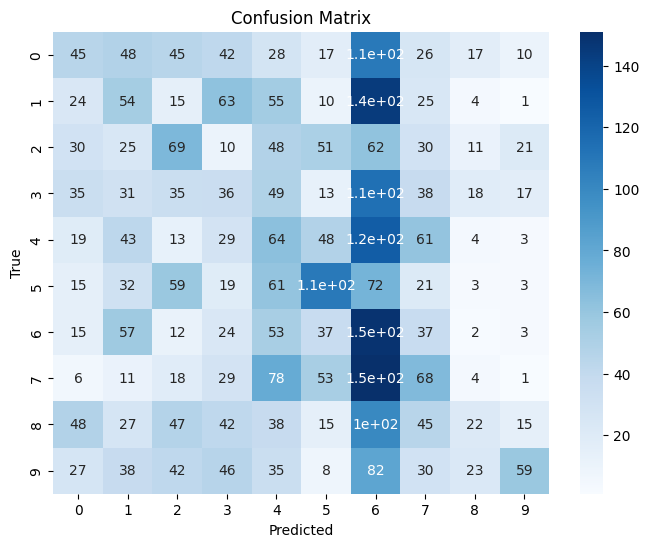

In [ ]:
# experiment with 30 cluster and SIFT and k = 7
start_time = time.time()
predictions_30_euc = classify_images(hist_img_data_train_30, train_labels, hist_img_data_test_30, k = 7)
end_time = time.time()
time_30_euc = end_time - start_time
accuracy_30_euc = accuracy_score(test_labels, predictions_30_euc)
cm_30_euc = confusion_matrix(test_labels, predictions_30_euc)
visualize_performance(accuracy_30_euc, cm_30_euc, time_30_euc)

### EXPERIMENT WITH ORB

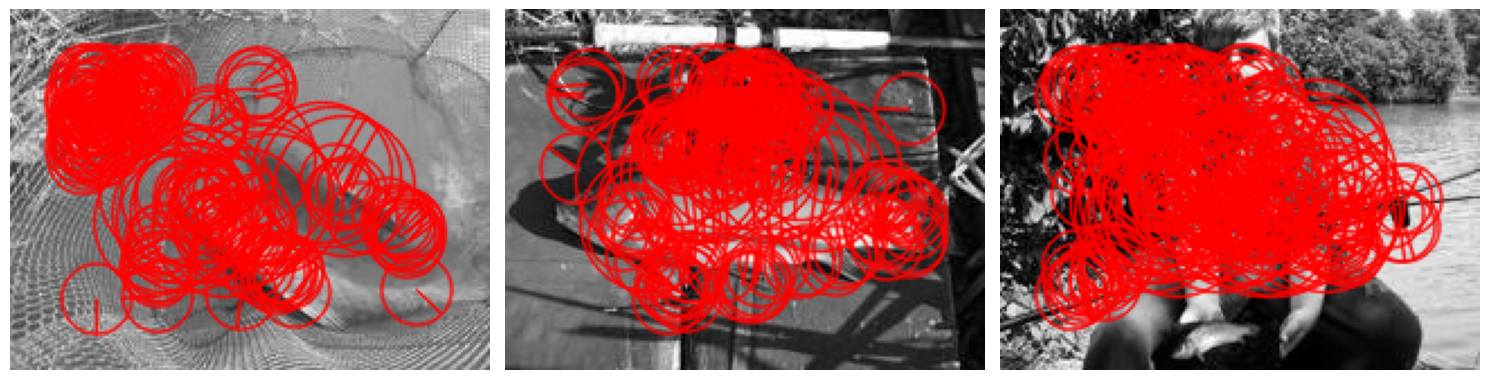

In [ ]:
# train data transformation
orb_descriptions_train = function_extraction(train_images, method="ORB",visualize=True)
orb_desc_stacked_train = prep_descriptions(orb_descriptions_train)

In [ ]:
# test data transformation
orb_descriptions_test = function_extraction(test_images, method="ORB")
orb_desc_stacked_test = prep_descriptions(orb_descriptions_test)

In [ ]:
# experiment with 50 cluster
hist_img_data_train_50 = transform_to_hist(orb_desc_stacked_train,orb_descriptions_train, 50)
hist_img_data_test_50 = transform_to_hist(orb_desc_stacked_test, orb_descriptions_test, 50)

Classification accuracy: 0.14267515923566879
Runtime: 0.1913158893585205


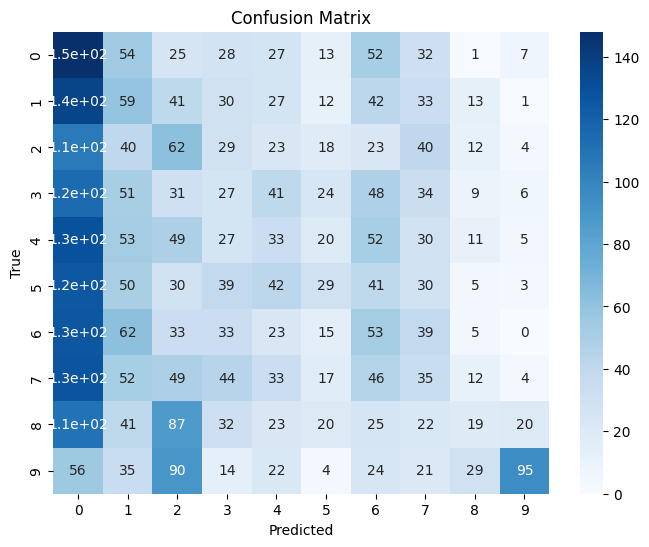

In [ ]:
# experiment with 50 cluster and SIFT and k = 7
start_time = time.time()
predictions_50_euc = classify_images(hist_img_data_train_50, train_labels, hist_img_data_test_50, k = 7)
end_time = time.time()
time_50_euc = end_time - start_time
accuracy_50_euc = accuracy_score(test_labels, predictions_50_euc)
cm_50_euc = confusion_matrix(test_labels, predictions_50_euc)
visualize_performance(accuracy_50_euc, cm_50_euc, time_50_euc)

## Summary of Experiments

The experiments involved several variations of the BoVW model:
Feature Extraction Methods:

SIFT (Scale-Invariant Feature Transform): This method identifies keypoints and computes descriptors based on local gradient information, making it robust to scale and rotation changes.

SIFT with Lowe's Ratio: This variation incorporates the Lowe's ratio test for keypoint matching, potentially improving the distinctiveness of the extracted features.
ORB (Oriented FAST and Rotated BRIEF): A faster alternative to SIFT, ORB is computationally efficient but probably less robust to image transformations.

Because of the bad accuracy in SIFT models i unfortunately fixated on them and did not experiment more on ORB. Since SIFT was more robust and elegant i expected much better results but unfortunately couldn't achieve them.


The provided data suggests that the model achieved bad accuracy across the different configurations. The highest accuracy achieved was approximately 17%, which indicates room for improvement. I tried several different models in the span of one week. While some took 7 hours some took 3 hours. Unfortunately I couldn't improve the accuracy overall. Here's a breakdown of the observations:

**Impact of Clustering:** The number of clusters in the K-Means algorithm  influenced accuracy. The results showed variations in performance with different cluster sizes, indicating the need for optimizing this parameter based on the specific dataset and feature extraction method. Because of the intertwined features across all classes (like a lot of people in fish and also trumpet class) I couldn't optimize this parameter. I tried several methods. First based on my experiments and then trying to find optimal sizes by github. One code found cluster_size is best when it is the square root of total feature size but this only increased the runtime and made model perform very badly predicting every class as 9.

**Impact of Classification:** The KNN classifier's performance was affected by both the number of neighbors (k) and the distance metric used. The optimal values for these parameters likely depend on the characteristics of the feature space and the distribution of classes in the dataset. Overall I realized at the very beginning cosine similarity was performing badly than euclidean so i decided to use only euclidean for more efficiency. But I couldn't find a good k value.


**The problems of the models:**

Too many predictions of zero/specific class: This observation suggests potential class imbalance issues in the dataset or biases in the model. It's probably the result of intertwined features in the dataset. Again like most classes have humans.

Model predicting only one class: This indicated a failure of the model to generalize and discriminate between different classes effectively. This happened when i make the cluster size - vocab size bigger. Which came to me as weird since more words should actually make the model perform better or learn the unique features in each class.




Overall below are the result i get from my experiments. Because of the run time and the multitude of models i run them in different notebooks and only took the best two in this notebook.

In [5]:
data = [
    [100, 5, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1472611465, ""],
    [100, 5, "Cosine", "SIFT", "-", "ORIGINAL", 0.1143949045, ""],
    [200, 5, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1284076433, "Too many predictions of zero"],
    [200, 5, "Cosine", "SIFT", "-", "ORIGINAL", 0.08942675159, "Too many predictions of zero"],
    [70, 3, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1431847134, ""],
    [70, 5, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1538853503, "Too many predictions of 6"],
    [70, 7, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1533757962, ""],
    [120, 3, "Euclidean", "SIFT", "-", "ORIGINAL", 0.127133758, ""],
    [120, 5, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1337579618, ""],
    [120, 7, "Euclidean", "SIFT", "-", "ORIGINAL", 0.1370700637, ""],
    [200, 3, "Euclidean", "SIFT", "nOctaveLayers=3,contrastThreshold=0.09", "ORIGINAL", 0.1187261146, "So much 0"],
    [30, 3, "Euclidean", "SIFT", "nOctaveLayers=3,contrastThreshold=0.10", "ORIGINAL", 0.1110828025, ""],
    [70, 3, "Euclidean", "SIFT", "nOctaveLayers=3,contrastThreshold=0.11", "ORIGINAL", 0.1077707006, ""],
    [30, 7, "Euclidean", "SIFT", "nOctaveLayers=3,contrastThreshold=0.11", "ORIGINAL", 0.1719745223, "Still many 6"],
    [820, "3-21-2007", "Euclidean", "SIFT", "nfeatures = 300, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6", 320, 0.09, "All of the models just predicted 9"],
    [1613, "3-9-21-121", "Euclidean", "SIFT", "-", 160, 0.1, "All of the models just predicted 9"],
    [50, "3", "Euclidean","ORB","nfeatures=250,scaleFactor=2","160",0.12636942675159235,"Mostly predicted zeros"],
    [50, "5", "Euclidean","ORB","nfeatures=250,scaleFactor=2","160",0.14089171974522294,"Mostly predicted zeros"],
    [50, "7", "Euclidean","ORB","nfeatures=250,scaleFactor=2","160",0.14267515923566879,"Mostly predicted zeros"]
]

# Create a Pandas DataFrame
df = pd.DataFrame(data, columns=[
    "K Means Cluster Size",
    "KNN (k Value)",
    "KNN Distance",
    "Feature Extraction Method",
    "Feature Extraction Parameters",
    "Pixel Size",
    "Accuracy",
    "Notes"
])

In [6]:
df

,K Means Cluster Size,KNN (k Value),KNN Distance,Feature Extraction Method,Feature Extraction Parameters,Pixel Size,Accuracy,Notes
0,100,5,Euclidean,SIFT,-,ORIGINAL,0.147261,
1,100,5,Cosine,SIFT,-,ORIGINAL,0.114395,
2,200,5,Euclidean,SIFT,-,ORIGINAL,0.128408,Too many predictions of zero
3,200,5,Cosine,SIFT,-,ORIGINAL,0.089427,Too many predictions of zero
4,70,3,Euclidean,SIFT,-,ORIGINAL,0.143185,
5,70,5,Euclidean,SIFT,-,ORIGINAL,0.153885,Too many predictions of 6
6,70,7,Euclidean,SIFT,-,ORIGINAL,0.153376,
7,120,3,Euclidean,SIFT,-,ORIGINAL,0.127134,
8,120,5,Euclidean,SIFT,-,ORIGINAL,0.133758,
9,120,7,Euclidean,SIFT,-,ORIGINAL,0.137070,
